<a href="https://colab.research.google.com/github/JSJeong-me/ResNet/blob/main/Remocon_Image_Classifcation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Train a Custom Resnet34 for Image Classification in fastai and PyTorch
Can I computer tell the diffence between a daisy and a dandelion? The answer is yes


This tutorial shows you how to train a state of the art image classification model with Resnet, in PyTorch, using the fastai library.

### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [how to train Resnet34 image classification model](https://blog.roboflow.ai/how-to-train-yolov5-on-a-custom-dataset/), concurrently.

### Steps Covered in this Tutorial

In this tutorial, we will walk through the steps required to train Resnet to recognize your custom classes. We use a [public flowers classification dataset](
https://public.roboflow.com/classification/flowers_classification), which is open source and free to use. You can also use this notebook on your own data.

To train our custom classifier we take the following steps:

* Install fastai dependencies
* Expand our training set via augmentations in Roboflow
* Download custom classificatio data from Roboflow
* Download pretrained Resnet Models
* Run frozen Resent training in fastai
* Find a favorable learning rate
* Run unfrozen training
* Inspect our model's evaluation metrics 
* Run Resnet inference on test images
* Export saved Resnet weights for future inference



# Install fastai dependencies

In [ ]:
!pip install fastai

In [2]:
from fastai.vision import *

# Download Custom Classification Data From Roboflow

In [ ]:
#follow the link below to get your download code from from Roboflow
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(model_format="folder", notebook="roboflow-resnet")

In [ ]:
#dataset imported from Roboflow. You can sign up at roboflow.com and upload your image classification dataset
# from roboflow import Roboflow
# rf = Roboflow(api_key="YOUR_API_KEY")
# project = rf.workspace().project("YOUR_PROJECT")
# dataset = project.version("YOUR VERSION").download("folder")


In [ ]:
!unzip ./remocon.v1i.folder.zip

In [ ]:
#dataset.location

In [7]:
#build fastai dataset loader
np.random.seed(42)
#fastai automatically factors the ./train and ./valid folders into seperate datasets
#more details https://docs.fast.ai/vision.data.html#ImageDataLoaders.from_folder
path = Path('./')
data = ImageDataBunch.from_folder(path, size=224, num_workers=4).normalize(imagenet_stats)

In [8]:
#double check the data classes
data.classes

['cup', 'eraser', 'remocon']

In [ ]:
#take a peak at the batch to make sure things were loaded correctly
data.show_batch(rows=3, figsize=(7, 8))


# Set up fastai Resnet model

In [10]:
from fastai.metrics import error_rate # 1 - accuracy
learn = create_cnn(data, models.resnet34, metrics=error_rate)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
#print network layers
learn

# Train Custom Resnet Image Classifier

In [12]:
from fastai.callbacks import *
early_stop = EarlyStoppingCallback(learn, patience=20)
save_best_model = SaveModelCallback(learn, name='best_resnet34')

In [13]:
#frozen training step
defaults.device = torch.device('cuda') # makes sure the gpu is used
learn.fit_one_cycle(1, callbacks=[early_stop, save_best_model])

epoch,train_loss,valid_loss,error_rate,time
0,0.815944,1.044770,0.270270,00:03


Better model found at epoch 0 with valid_loss value: 1.0447704792022705.


In [ ]:
#load best model from frozen training
learn.load('best_resnet34')


In [15]:
learn.unfreeze()

In [16]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    min_loss_index = np.argmin(losses)
    
    
    #loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #return the learning rate that produces the minimum loss divide by 10   
    return lrs[min_loss_index] / 10

In [17]:
optimal_lr = find_appropriate_lr(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [18]:
learn.fit_one_cycle(50, max_lr=slice(optimal_lr/10, optimal_lr), callbacks=[early_stop, save_best_model])


epoch,train_loss,valid_loss,error_rate,time
0,0.056041,0.466625,0.162162,00:02
1,0.034760,0.206713,0.094595,00:02
2,0.026341,0.059145,0.027027,00:02
3,0.020925,0.028692,0.013514,00:02
4,0.016118,0.014378,0.013514,00:02
5,0.012926,0.005426,0.000000,00:02
6,0.010750,0.001857,0.000000,00:02
7,0.008700,0.001065,0.000000,00:02
8,0.007174,0.000985,0.000000,00:02
9,0.005956,0.001258,0.000000,00:02


Better model found at epoch 0 with valid_loss value: 0.466624915599823.
Better model found at epoch 1 with valid_loss value: 0.20671267807483673.
Better model found at epoch 2 with valid_loss value: 0.05914502590894699.
Better model found at epoch 3 with valid_loss value: 0.028692122548818588.
Better model found at epoch 4 with valid_loss value: 0.014377912506461143.
Better model found at epoch 5 with valid_loss value: 0.0054262978956103325.
Better model found at epoch 6 with valid_loss value: 0.0018570448737591505.
Better model found at epoch 7 with valid_loss value: 0.0010647294111549854.
Better model found at epoch 8 with valid_loss value: 0.0009846852626651525.
Better model found at epoch 11 with valid_loss value: 0.0009164699586108327.
Better model found at epoch 12 with valid_loss value: 0.0005576217663474381.
Better model found at epoch 13 with valid_loss value: 0.0005515683442354202.
Epoch 34: early stopping


In [ ]:
learn.load('best_resnet34')


# Evaluate Classifier Performance

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


In [ ]:
interp.plot_top_losses(9, figsize=(15,15))


/content/test/cup/66_jpg.rf.946060fbec4d6471429aa503b5772354.jpg
cup


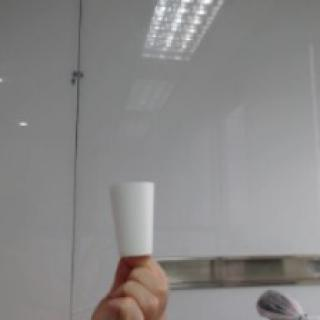



/content/test/cup/46_jpg.rf.78144cf009d35b317833d9413152625b.jpg
cup


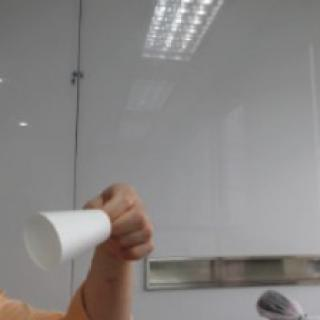



/content/test/cup/88_jpg.rf.571772d3a690ba8baafeb47a4afb5f0d.jpg
cup


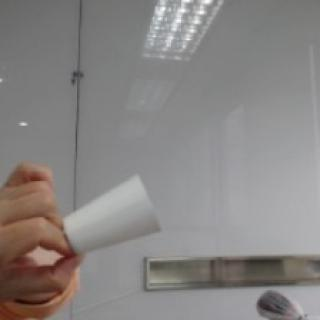



/content/test/cup/45_jpg.rf.f2c259894a479c0c71e2a5f5924c3900.jpg
cup


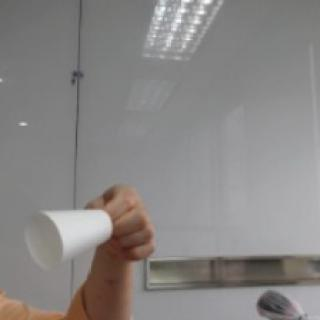



/content/test/cup/81_jpg.rf.ac4fb9d25554b0f7547e8b7077a14186.jpg
cup


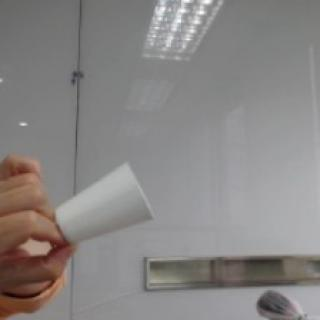



/content/test/cup/146_jpg.rf.763f91f5b10f884370d7e1209514df95.jpg
cup


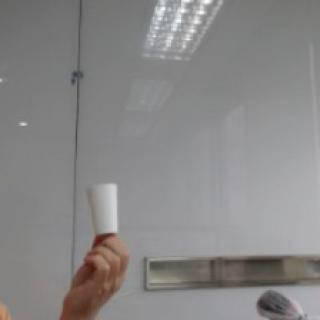



/content/test/cup/169_jpg.rf.44fc6213d1ab524bc0522a830825ab1d.jpg
cup


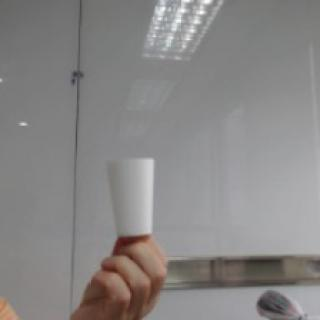



/content/test/cup/100_jpg.rf.29bbd0cba54c7bd1bc88399f0379ea42.jpg
cup


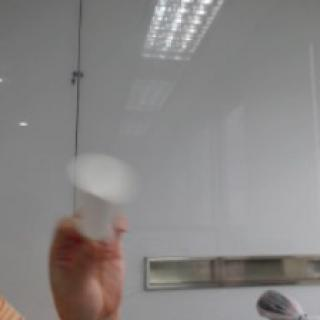



/content/test/cup/97_jpg.rf.d04b26d0c58e1c514b1d9ae4651d57de.jpg
cup


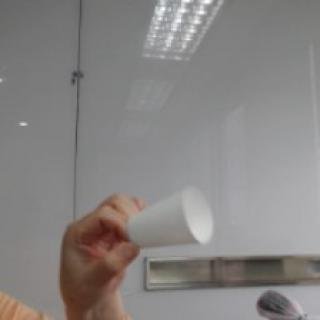



/content/test/cup/35_jpg.rf.92e408907c41899af63c30f0832ff7bd.jpg
cup


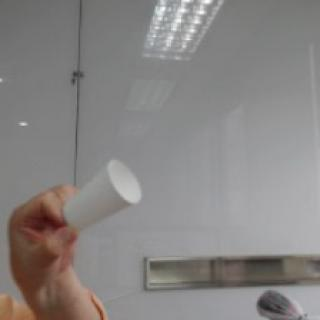



/content/test/cup/2_jpg.rf.91ff366ab0540c242e68d4932adc4c26.jpg
cup


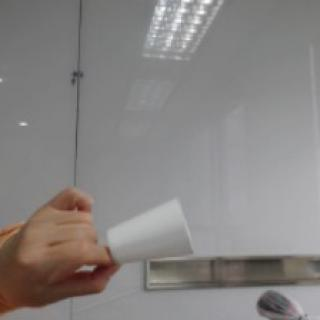



/content/test/cup/147_jpg.rf.8f84ae2afcd225694b73f820caadefdb.jpg
cup


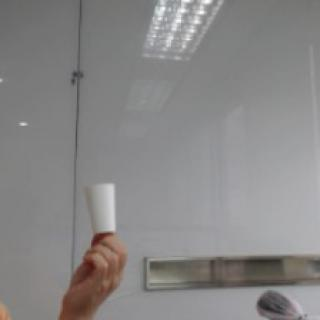



/content/test/cup/141_jpg.rf.537ff525b369374dfb2c106f839e2e26.jpg
cup


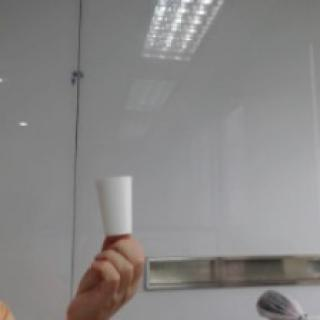



/content/test/cup/92_jpg.rf.1b4b49bd3b18f7602c062fdbfe7b9bef.jpg
cup


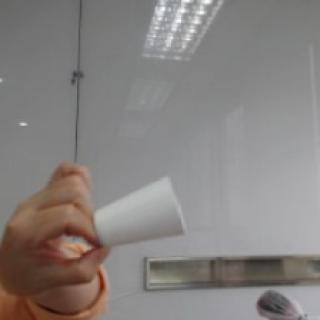



/content/test/eraser/70_jpg.rf.58c2d3e71b8f07373e283a1709caae61.jpg
eraser


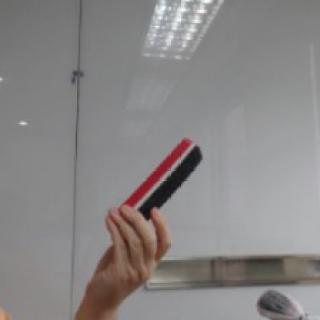



/content/test/eraser/63_jpg.rf.fff34eb99e1b8fd494ad2375c3ea9511.jpg
eraser


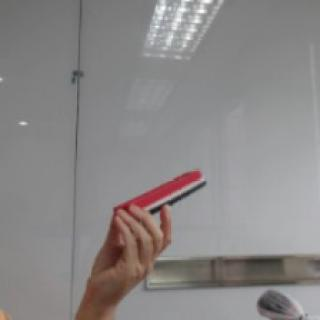



/content/test/eraser/126_jpg.rf.f63d57f9f84cb1a3e534d07a46e5b9ca.jpg
eraser


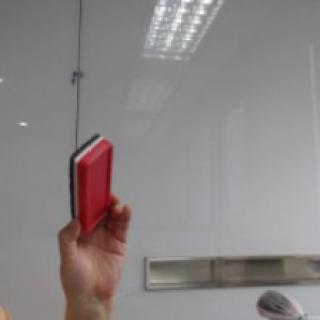



/content/test/eraser/84_jpg.rf.28377d4877679d1b1cd29572e13a02c3.jpg
eraser


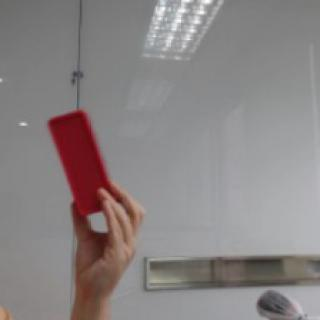



/content/test/eraser/18_jpg.rf.0062a9493f993c1562b87686ef01e0b2.jpg
eraser


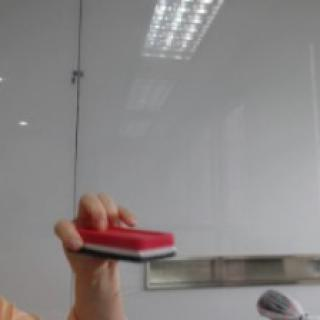



/content/test/eraser/30_jpg.rf.35189de8d05bfc59798f047e0cb69397.jpg
eraser


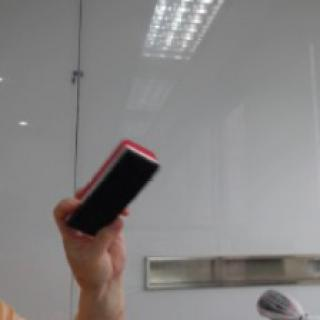



/content/test/remocon/96_jpg.rf.6bcf7b9553dfc7362197f5adbb822618.jpg
remocon


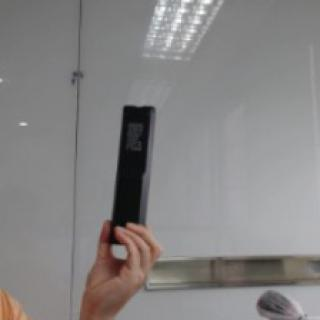



/content/test/remocon/44_jpg.rf.d1f826597c40246cbc6abab53c735121.jpg
remocon


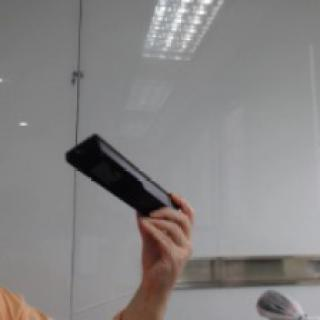



/content/test/remocon/14_jpg.rf.01aecda3ca9c57746051639101fd0651.jpg
remocon


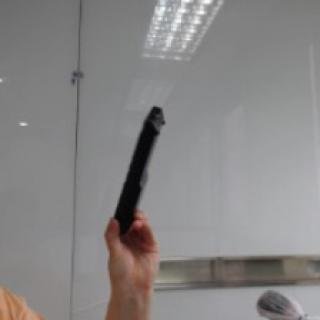



/content/test/remocon/136_jpg.rf.e7963e53b87654615c6c6a8375e2155c.jpg
remocon


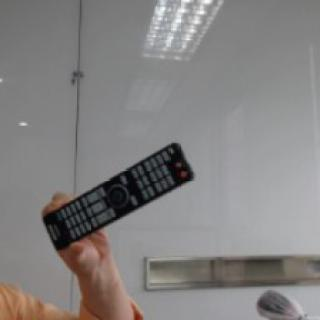



/content/test/remocon/59_jpg.rf.bf43447fb79ced93b0231abb017cc846.jpg
remocon


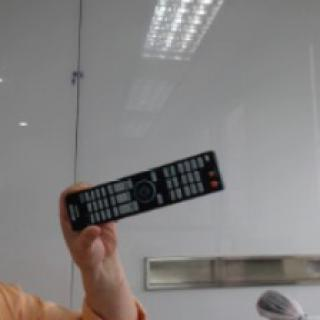



/content/test/remocon/83_jpg.rf.8fb5e19a9b18b4869f589fda5f1e0b78.jpg
remocon


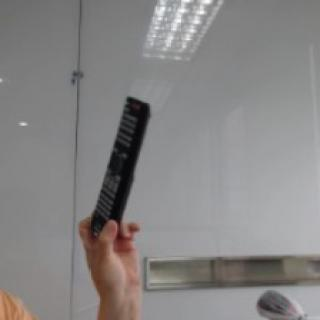



/content/test/remocon/171_jpg.rf.0258eb78730211677930c3de229c14ff.jpg
remocon


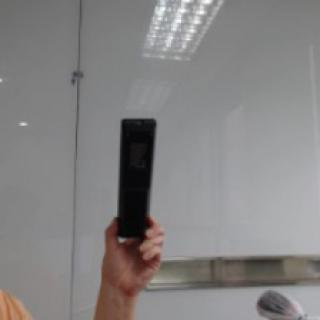



/content/test/remocon/178_jpg.rf.e6f82e6d1609080f5baf43e42acacca5.jpg
remocon


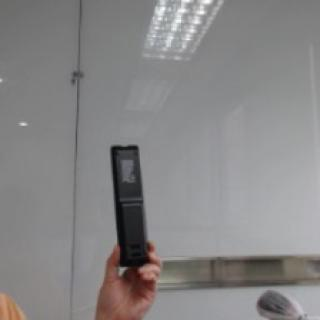



/content/test/remocon/202_jpg.rf.91066f0ffc5471a0e9cee688443527aa.jpg
remocon


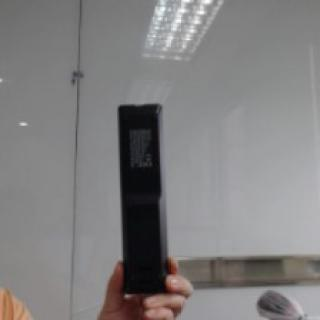



/content/test/remocon/54_jpg.rf.90680fea1fd114c710cec100d61bdad8.jpg
remocon


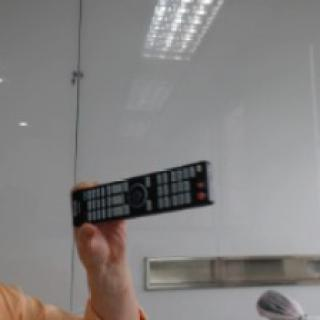



/content/test/remocon/89_jpg.rf.d0712a06ec30fab661f8025b96bb4aa6.jpg
remocon


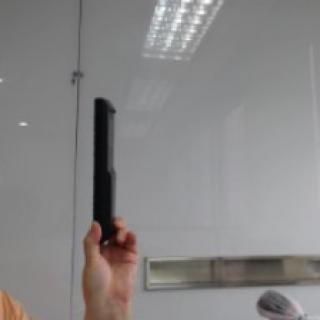



/content/test/remocon/73_jpg.rf.152e3c38be6c8ef6e044153c7220c87c.jpg
remocon


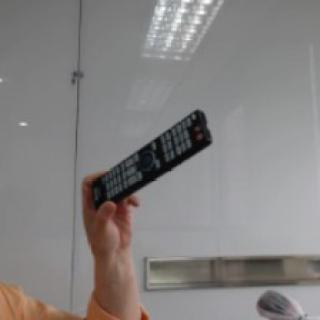



/content/test/remocon/68_jpg.rf.edcc7f03bd5e8807735f0ddc1d0517be.jpg
remocon


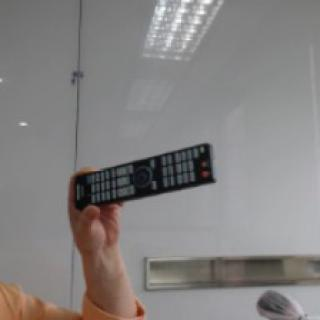



/content/test/remocon/117_jpg.rf.1053eeee5f3afea33f2d6a7c2003ea5d.jpg
remocon


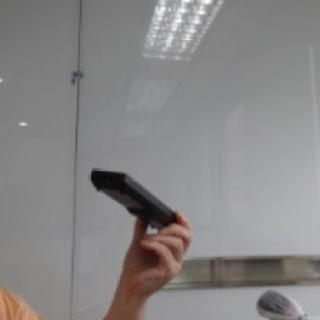



/content/test/remocon/46_jpg.rf.0c91b1e04583c88438083a014a12747f.jpg
remocon


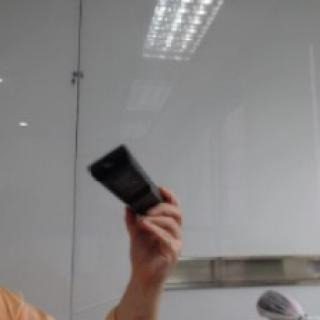



/content/test/remocon/42_jpg.rf.ca7b2b498efc85da2ca6343cc11c3b13.jpg
remocon


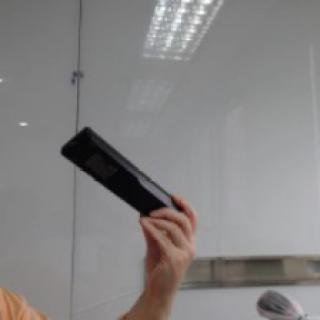



/content/test/remocon/160_jpg.rf.d8e76243db717bea13834e4ab167003a.jpg
remocon


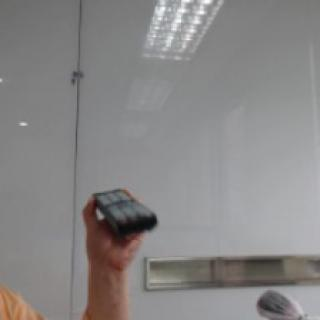

In [22]:
#run inference on test images
import glob
from IPython.display import Image, display

model = learn.model
#model = model.cuda()
for imageName in glob.glob('/content/test/*/*.jpg'):
    print(imageName)
    img = open_image(imageName)
    prediction = learn.predict(img)
    #print(prediction)
    print(prediction[0])
    display(Image(filename=imageName))
    print("\n")

# Save custom classification model for future use

In [ ]:
#model is automatically saved with the "save_best_model" callback
%ls models/

In [ ]:
from google.colab import files
files.download('./models/best_resnet34.pth')